<img src="https://i.imgur.com/d28OeSq.png" width="350px" align="right">

# `Finance with Python 03`

* static three state economy | dealing with market incompleteness
* state multi state economy | generalizing the state space

Credit to Dr. Yves Hilpisch of The Python Quants for instructional material https://tpq.io/

In [1]:
import pandas as pd
import numpy as np

## Market | Redoing Mean-Variance Portfolio 

In [2]:
'''Strike Price'''
K = 15.

In [3]:
'''Stock | Bond | Call Option'''
S = np.array((20., 10., 5.))
B = np.array((11, 11, 11)) # remember the bond is riskless, hence 3 payoffs of 11
C = np.maximum(S - K, 0)

In [4]:
'''Market Matrix'''
M = np.array((S, B, C)).T
M

array([[20., 11.,  5.],
       [10., 11.,  0.],
       [ 5., 11.,  0.]])

In [5]:
'''Stock | Bond | Call at time 0'''
S0 = 10.
B0 = 10.
C0 = 1.

In [6]:
'''Market at time 0'''
M0 = np.array((S0, B0, C0))
M0

array([10., 10.,  1.])

In [7]:
'''Returns Matrix'''
R = M / M0 -1
R

array([[ 1. ,  0.1,  4. ],
       [ 0. ,  0.1, -1. ],
       [-0.5,  0.1, -1. ]])

## Calculating Statistics 

In [8]:
'''expected returns per asset'''
R.mean(axis=0)

array([0.16666667, 0.1       , 0.66666667])

In [9]:
def mu(phi):
    return np.dot(R.mean(axis=0), phi)

In [10]:
'''portfolio weights'''
phi = [1/3] * 3
phi

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [11]:
'''average portfolio return'''
mu(phi)

0.3111111111111111

In [12]:
'''vol by asset'''
R.std(axis=0)

array([0.62360956, 0.        , 2.3570226 ])

In [13]:
'''covariance matrix WRONG WAY''' 
np.cov(R)
# must transpose with .T 

array([[ 4.17      , -1.23      , -1.055     ],
       [-1.23      ,  0.37      ,  0.295     ],
       [-1.055     ,  0.295     ,  0.30333333]])

In [14]:
'''covariance matrix'''
np.cov(R.T)
# must transpose with .T to account for B, a riskless asset

array([[0.58333333, 0.        , 2.08333333],
       [0.        , 0.        , 0.        ],
       [2.08333333, 0.        , 8.33333333]])

In [15]:
R.std(axis=0) ** 2

array([0.38888889, 0.        , 5.55555556])

In [16]:
'''double dot product for portfolio vol'''
def sigma(phi):
    return np.dot(phi, np.dot(np.cov(R.T), phi)) ** .5 # .5 ==sqrt

In [17]:
'''portfolio vol'''
sigma(phi)

1.2056963563450391

In [18]:
'''checking sigma function'''
phi_bond = [0, 1, 0]
sigma(phi_bond)

0.0

## Monte Carlo Simulation

In [19]:
'''long only, no shorts'''
rn = np.random.random((500, 3)) # 500 rows, 3 columns of pseudo random numbers - verify with phi_rn.shape
phi_rn = (rn.T / rn.sum(axis=1)).T

In [20]:
phi_rn.shape

(500, 3)

In [21]:
'''checking sum of 500 portfolio compositions add to 1'''
phi_rn.sum(axis=1)[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
'''risk-return combinations'''
'''list comprehension approach'''
rr = np.array([(sigma(phi), mu(phi)) for phi in phi_rn]) #portfolio risk and portfolio return

In [23]:
'''checking first 5 rows of risk | return'''
rr[:5]

array([[2.15431178, 0.50011824],
       [1.85708603, 0.45490053],
       [2.50272217, 0.58092606],
       [1.53388541, 0.35581579],
       [1.64454423, 0.38327858]])

In [24]:
'''plotting risk and return'''
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

Text(0, 0.5, 'Expected Return')

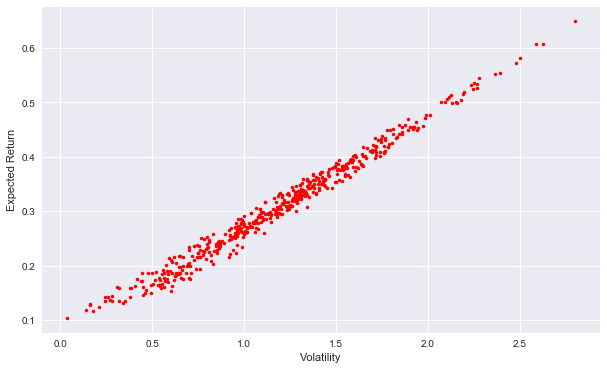

In [25]:
plt.figure(figsize=(10,6))
plt.plot(rr[:,0], rr[:,1], 'r.'); # 3rd argument is color (b. == blue r.==red g.==green)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')

> There was a question about "Markowitz Bullet" re: above plotting; we had already accounted for riskless asset so, resulting plot was not MB

<img src="https://i.imgur.com/O3cXOtP.png" width="720px" align="center">

Above image credit to Thomas Wiecki and Quantopian 
https://blog.quantopian.com/markowitz-portfolio-optimization-2/

<img src="https://cdn-images-1.medium.com/max/1600/1*RQrjkJQhgVLnpyo1lXbizA.png" width="720px" align="center">

Above image credit to Fábio Neves at https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5</a>

## Option Pricing Revisited &mdash; Incomplete Markets

In [26]:
M = np.array((S, B)).T
M

array([[20., 11.],
       [10., 11.],
       [ 5., 11.]])

In [27]:
'''Linear transformation of linearly dependent vector'''
D = 3.75 * B + 0.5
D

array([41.75, 41.75, 41.75])

In [28]:
# https://docs.scipy.org/doc/numpy-1.14.2/reference/generated/numpy.linalg.matrix_rank.html
np.linalg.matrix_rank(M)

2

In [29]:
M0 = np.array((S0, B0))
M0

array([10., 10.])

## Ordinary Least Squares Regression Based Pricing

In [30]:
'''solve a system of linear equations for replications'''
reg = np.linalg.lstsq(M, C, rcond=None) # pass rcond to avoid update message
reg

(array([ 0.35714286, -0.22727273]),
 array([1.78571429]),
 2,
 array([28.93835724,  7.11136277]))

In [31]:
'''payoffs of regression-based portfolios'''
Creg = np.dot(M, reg[0])
Creg

array([ 4.64285714,  1.07142857, -0.71428571])

In [32]:
'''vector subtraction for sum of squared errors'''
((Creg - C) ** 2).sum() # <---- a benchmark

1.785714285714286

In [33]:
'''the aproximated option price given the regression-based portfolio'''
C0reg = np.dot(M0, reg[0])
C0reg

1.2987012987012996

## Neural Net Based Pricing 

In [34]:
'''weights vector'''
w = np.array((1., -1.))

In [35]:
'''layer 1'''
l1 = np.dot(M, w)
l1

array([ 9., -1., -6.])

In [36]:
'''deltas'''
d = l1 - C
d

array([ 4., -1., -6.])

In [37]:
'''right sizing the vectors'''
u = np.dot(M.T, d)
u

array([ 40., -33.])

In [38]:
'''the learning rate'''
alpha = 0.001

In [39]:
'''learning values'''
w -= alpha * u
w

array([ 0.96 , -0.967])

In [40]:
'''vector subtraction for sum of squared errors'''
((l1 - C) ** 2).sum() 

53.0

In [41]:
'''loop of above'''
for _ in range(25):
    l1 = np.dot(M, w)
    print(((l1 - C) ** 2).sum())
    d = l1 - C
    u = np.dot(M.T, d)
    w -= alpha * u
print(((l1 - C) ** 2).sum())
print(w)
print(l1)

47.840907
43.297623340757994
39.20507468903455
35.516066815618174
32.19074355622216
29.193248959609274
26.49126382672889
24.055655212060508
21.86016225699403
19.881113042469515
18.09716935707904
16.48909662736211
15.03955652963574
13.732920047288061
12.55509895790953
11.49339393334733
10.536357614889653
9.673671187249639
8.896033120563038
8.195058880810176
7.563190527334711
6.993615222734986
6.4801917764973656
6.017384430361163
5.60020317148561
5.60020317148561
[ 0.52144947 -0.42974478]
[ 5.75820133  0.45618845 -2.19481799]


## Super-Replication

In [42]:
from scipy.optimize import minimize

In [43]:
'''bond payoff on super replication'''
Csr = 5 / 11 * B
Csr

array([5., 5., 5.])

In [44]:
'''satisifies requirement that Csr is greater than or equal to C'''
'''The payoff Csr dominates C'''
Csr >= C

array([ True,  True,  True])

In [45]:
'''C dominated Creg'''
Creg >= C

array([False,  True, False])

<font color=red> trying to find the portfolio which costs the least to set up

In [46]:
cons = ({'type': 'ineq', 'fun': lambda phi: np.dot(M, phi) - C})

In [47]:
'''costs of portfolio phi'''
def cost(phi):
    return np.dot(M0, phi)

In [48]:
sr = minimize(cost, (1, -1), constraints=cons)
sr

     fun: 1.8181818181675702
     jac: array([10., 10.])
 message: 'Optimization terminated successfully.'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.33333333, -0.15151515])

In [49]:
'''payoff of this portfolio'''
Csr = np.dot(M, sr['x'])
Csr.round(3)

array([ 5.   ,  1.667, -0.   ])

In [50]:
Csr >= C

array([False,  True, False])

In [51]:
'''different starting point'''
sr = minimize(cost, (0.5, -0.5), constraints=cons)
sr

     fun: 1.8181818181845344
     jac: array([10., 10.])
 message: 'Optimization terminated successfully.'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.33333333, -0.15151515])

In [52]:
'''payoff of this portfolio'''
Csr = np.dot(M, sr['x'])
Csr.round(3)

array([5.   , 1.667, 0.   ])

In [53]:
Csr >= C

array([ True,  True,  True])

## General State Space &mdash; "Many Discrete" States 

In the BSM 1973 model based on the geometric brownian motion the future price ST of the risky stock is given in a discrete simulation context by the following

$$S_T = S_0 \cdot \exp \left(\left(r - \frac{\sigma^2}{2} \right)T + \sigma \sqrt{T} z\right)$$

$S_0$ is the intial price, $r$ the risk-free short rate, $\sigma$ the volatility factor in the model, $T>0$ a future point inthe time and $Z$ a standard normally distributed rv.

In [54]:
'''Parameters'''
import math
S0 = 100.
r = 0.05
sigma = 0.2
T = 1.0
'''simulation'''
z = np.random.standard_normal(10000)

In [55]:
z.mean()

-0.0005744893491633376

In [56]:
z.std()

0.9945296998387557

In [57]:
ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * z)

In [58]:
'''checking first 10 values'''
ST[:10]

array([101.93546783, 132.31044059,  79.33526829,  95.82255435,
        93.85728268, 130.20019558, 124.89086677, 107.80708608,
        79.05846883,  78.99572954])

In [59]:
'''sanity check::expected value'''
S0 * math.exp(r * T)

105.12710963760242

In [60]:
'''should be closer to above? may be due to porr set of random dist set'''
ST.mean()

105.09116853517175

Text(0, 0.5, 'frequency')

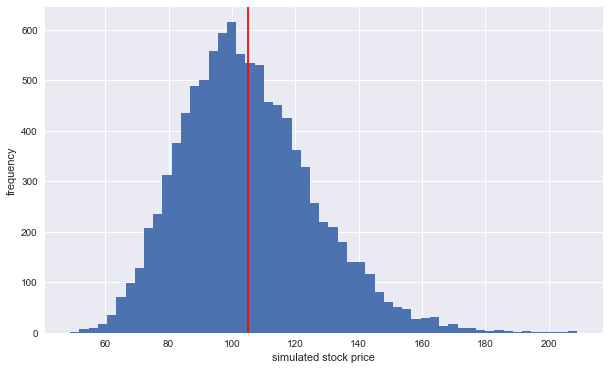

In [61]:
'''visualize'''
plt.figure(figsize=(10, 6))
plt.hist(ST, bins=55)
plt.axvline(ST.mean(), c='r')
plt.xlabel('simulated stock price')
plt.ylabel('frequency')

In [62]:
ST.sort()

In [63]:
'''Risk Neutral Option Pricing''' 
'''option payoff'''
K = 105.
CT = np.maximum(ST - K, 0)
CT

array([  0.        ,   0.        ,   0.        , ..., 102.18600406,
       103.04082261, 104.09159958])

In [64]:
'''pricing of the option with monte carlo simulation'''
C0mcs = math.exp(-r * T) * CT.mean()
C0mcs

7.954830511015108

## Option Payoff Approximation

In [65]:
'''bonds'''
BT = 100 * math.exp(r * T) * np.ones(len(ST))
BT

array([105.12710964, 105.12710964, 105.12710964, ..., 105.12710964,
       105.12710964, 105.12710964])

In [66]:
'''market matrix'''
MT = np.array((ST, BT)).T

In [67]:
reg = np.linalg.lstsq(MT, CT, rcond=None)

In [68]:
reg

(array([ 0.57983846, -0.50009192]),
 array([392662.15670185]),
 2,
 array([14940.07328885,  1484.53909996]))

In [69]:
CTreg = np.dot(MT, reg[0])
CTreg

array([-24.21790549, -22.51410034, -22.05792759, ...,  67.56119577,
        68.05685245,  68.66613335])

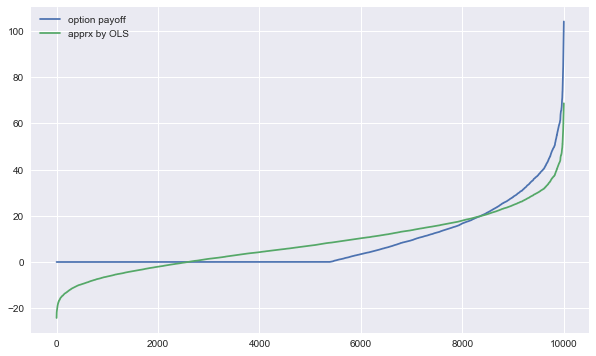

In [70]:
'''visualize'''
plt.figure(figsize=(10, 6))
plt.plot(CT, label='option payoff')
plt.plot(CTreg, label='apprx by OLS')
plt.legend(loc=0)

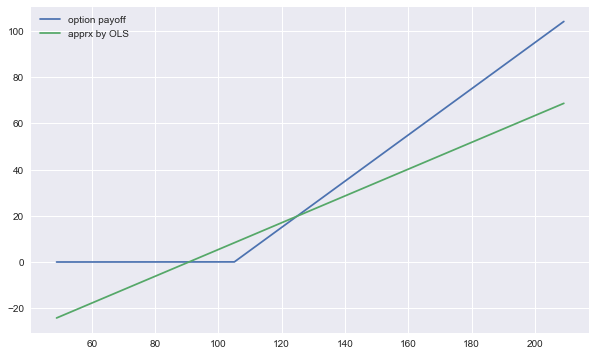

In [71]:
'''visualize'''
plt.figure(figsize=(10, 6))
plt.plot(ST, CT, label='option payoff')
plt.plot(ST, CTreg, label='apprx by OLS')
plt.legend(loc=0)

<img src="https://i.imgur.com/d28OeSq.png" width="350px" align="right">